# Component Identification Recursive

In [1]:
from __future__ import annotations
import json
import argparse
from pathlib import Path
from dataclasses import dataclass, field
from typing import Dict, List, Optional
from collections import Counter
import os
from dotenv import load_dotenv

load_dotenv()
URL = os.getenv('URL')
print(URL)

folder_name = URL.rstrip("/").replace("://","_").replace("/","_")

@dataclass
class DomNode:
    xpath: str
    tag: str
    meta: Dict
    children: List["DomNode"] = field(default_factory=list)
    parent: Optional["DomNode"] = None

    # algorithmic fields
    psi: float = 1.0
    is_instance: bool = False



https://github.com/facebook


In [2]:
def parent_xpath(xp: str) -> Optional[str]:
    core = xp.strip("/")
    if "/" not in core:
        return None
    return xp.rsplit("/", 1)[0]


def build_dom_tree(elem_source: List[Dict]) -> DomNode:
    
    # --- normalise to {xpath: element‑dict} ---------------------------------
    if isinstance(elem_source, list):
        elem_map: Dict[str, Dict] = {e["xpath"]: e for e in elem_source if "xpath" in e}

    # --- create DomNode objects --------------------------------------------
    nodes: Dict[str, DomNode] = {}
    for xp, meta in elem_map.items():
        tag = (meta.get("tagName") or "div").lower()
        nodes[xp] = DomNode(xpath=xp, tag=tag, meta=meta)

    # --- synthesise missing ancestors --------------------------------------
    queue = list(nodes.keys())
    while queue:
        xp = queue.pop()
        px = parent_xpath(xp)
        if px and px not in nodes:
            inferred_tag = px.rsplit("/", 1)[-1].split("[")[0]
            nodes[px] = DomNode(xpath=px, tag=inferred_tag, meta={"placeholder": True})
            queue.append(px)

    # --- wire parent / children --------------------------------------------
    for xp, node in nodes.items():
        px = parent_xpath(xp)
        if px:
            node.parent = nodes[px]
            nodes[px].children.append(node)

    # --- root = shortest xpath ---------------------------------------------
    root_xp = min(nodes.keys(), key=len)
    return nodes[root_xp]

In [3]:
with open(f"{folder_name}/elements.json") as f:
    VISUAL_LEAF_PATHS = {rec["xpath"] for rec in json.load(f)}
    
def tag_multiset(n: DomNode, depth: int = 3) -> Counter:
    if depth == 0:
        return Counter()
    sig = Counter([n.tag])
    for ch in n.children:
        sig += tag_multiset(ch, depth - 1)
    return sig


def jaccard_distance(a: DomNode, b: DomNode) -> float:
    """Cheap structural distance in [0,1]."""
    sa, sb = tag_multiset(a), tag_multiset(b)
    inter = sum((sa & sb).values())
    union = sum((sa | sb).values())
    return 1.0 - (inter / union) if union else 0.0


def subtree_size_pruned(node, visual_leaf_paths=VISUAL_LEAF_PATHS):
    """
    Count ONLY those descendants whose XPath is in `visual_leaf_paths`.
    Every entry in elements.json is treated as exactly **one** unit.
    """
    # If this node *itself* is in the visual list, stop – it is a leaf by definition
    if node.xpath in visual_leaf_paths:
        return 1

    # Otherwise add up the pruned sizes of the children
    return sum(subtree_size_pruned(c, visual_leaf_paths) for c in node.children)

In [4]:
def calculate_psi(node: DomNode) -> float:
    """Post‑order traversal deciding whether *node* or its children become instances."""

    # recurse down first
    child_psis = [calculate_psi(ch) for ch in node.children]
    psi_children = 1.0
    for v in child_psis:
        psi_children *= v

    # local score = |subtree| / (1 + Σ sibling‑distance)
    if node.parent is None:
        sibling_sum = 0.0
    else:
        sibling_sum = sum(
            jaccard_distance(node, sib)
            for sib in node.parent.children
            if sib is not node
        )
    psi_root = subtree_size_pruned(node) / (1.0 + sibling_sum)

    # choose winner for this subtree
    if psi_root >= psi_children:
        node.psi = psi_root
        node.is_instance = True
        return psi_root
    else:
        node.psi = psi_children
        node.is_instance = False
        return psi_children

In [5]:
def gather_instances(root: DomNode) -> Dict[str, int]:
    instances: Dict[str, int] = {}

    def walk(n: DomNode):
        if n.is_instance:
            instances[n.xpath] = subtree_size_pruned(n)
        else:
            for ch in n.children:
                walk(ch)

    walk(root)
    return instances

In [6]:
# Tree Visualization 
def ascii_tree(node: "DomNode", indent: str = "", is_last: bool = True) -> str:
    """Return a multi-line string with │── branches."""
    branch = "└── " if is_last else "├── "
    line = f"{indent}{branch}{node.tag}  ψ={node.psi:.2f}{' *' if node.is_instance else ''}\n"
    indent_child = indent + ("    " if is_last else "│   ")
    for i, ch in enumerate(node.children):
        line += ascii_tree(ch, indent_child, i == len(node.children) - 1)
    return line

In [7]:
result_file = f"{folder_name}/reucr_res.json"


# --- Load leaf XPaths from elements.json ---
with open(f'{folder_name}/elements.json', 'r', encoding='utf-8') as f:
    elements = json.load(f)
leaf_xpaths = [el['xpath'] for el in elements]
print(f"Loaded {len(leaf_xpaths)} leaf XPaths from elements.json")


Loaded 369 leaf XPaths from elements.json


In [8]:
elem_dict = elements
root = build_dom_tree(elem_dict)
calculate_psi(root)
instances = gather_instances(root)

# for xpath, cnt in instances.items():
#     print(f"{xpath} -> {cnt} elements")

In [9]:
print(ascii_tree(root))

└── html  ψ=58094218833055530876928.00
    └── body  ψ=58094218833055530876928.00
        └── div  ψ=58094218833055530876928.00
            ├── div  ψ=5809421883305553297408.00
            │   └── main  ψ=5809421883305553297408.00
            │       └── div  ψ=5809421883305553297408.00
            │           ├── div  ψ=105625852423737327616.00
            │           │   └── div  ψ=105625852423737327616.00
            │           │       ├── div  ψ=4224.00
            │           │       │   └── div  ψ=4224.00
            │           │       │       ├── div  ψ=22.00
            │           │       │       │   └── div  ψ=22.00 *
            │           │       │       │       └── div  ψ=22.00 *
            │           │       │       │           ├── div  ψ=6.83 *
            │           │       │       │           │   ├── a  ψ=1.00 *
            │           │       │       │           │   │   └── img  ψ=1.00 *
            │           │       │       │           │   ├── a  ψ=1.00 *
   

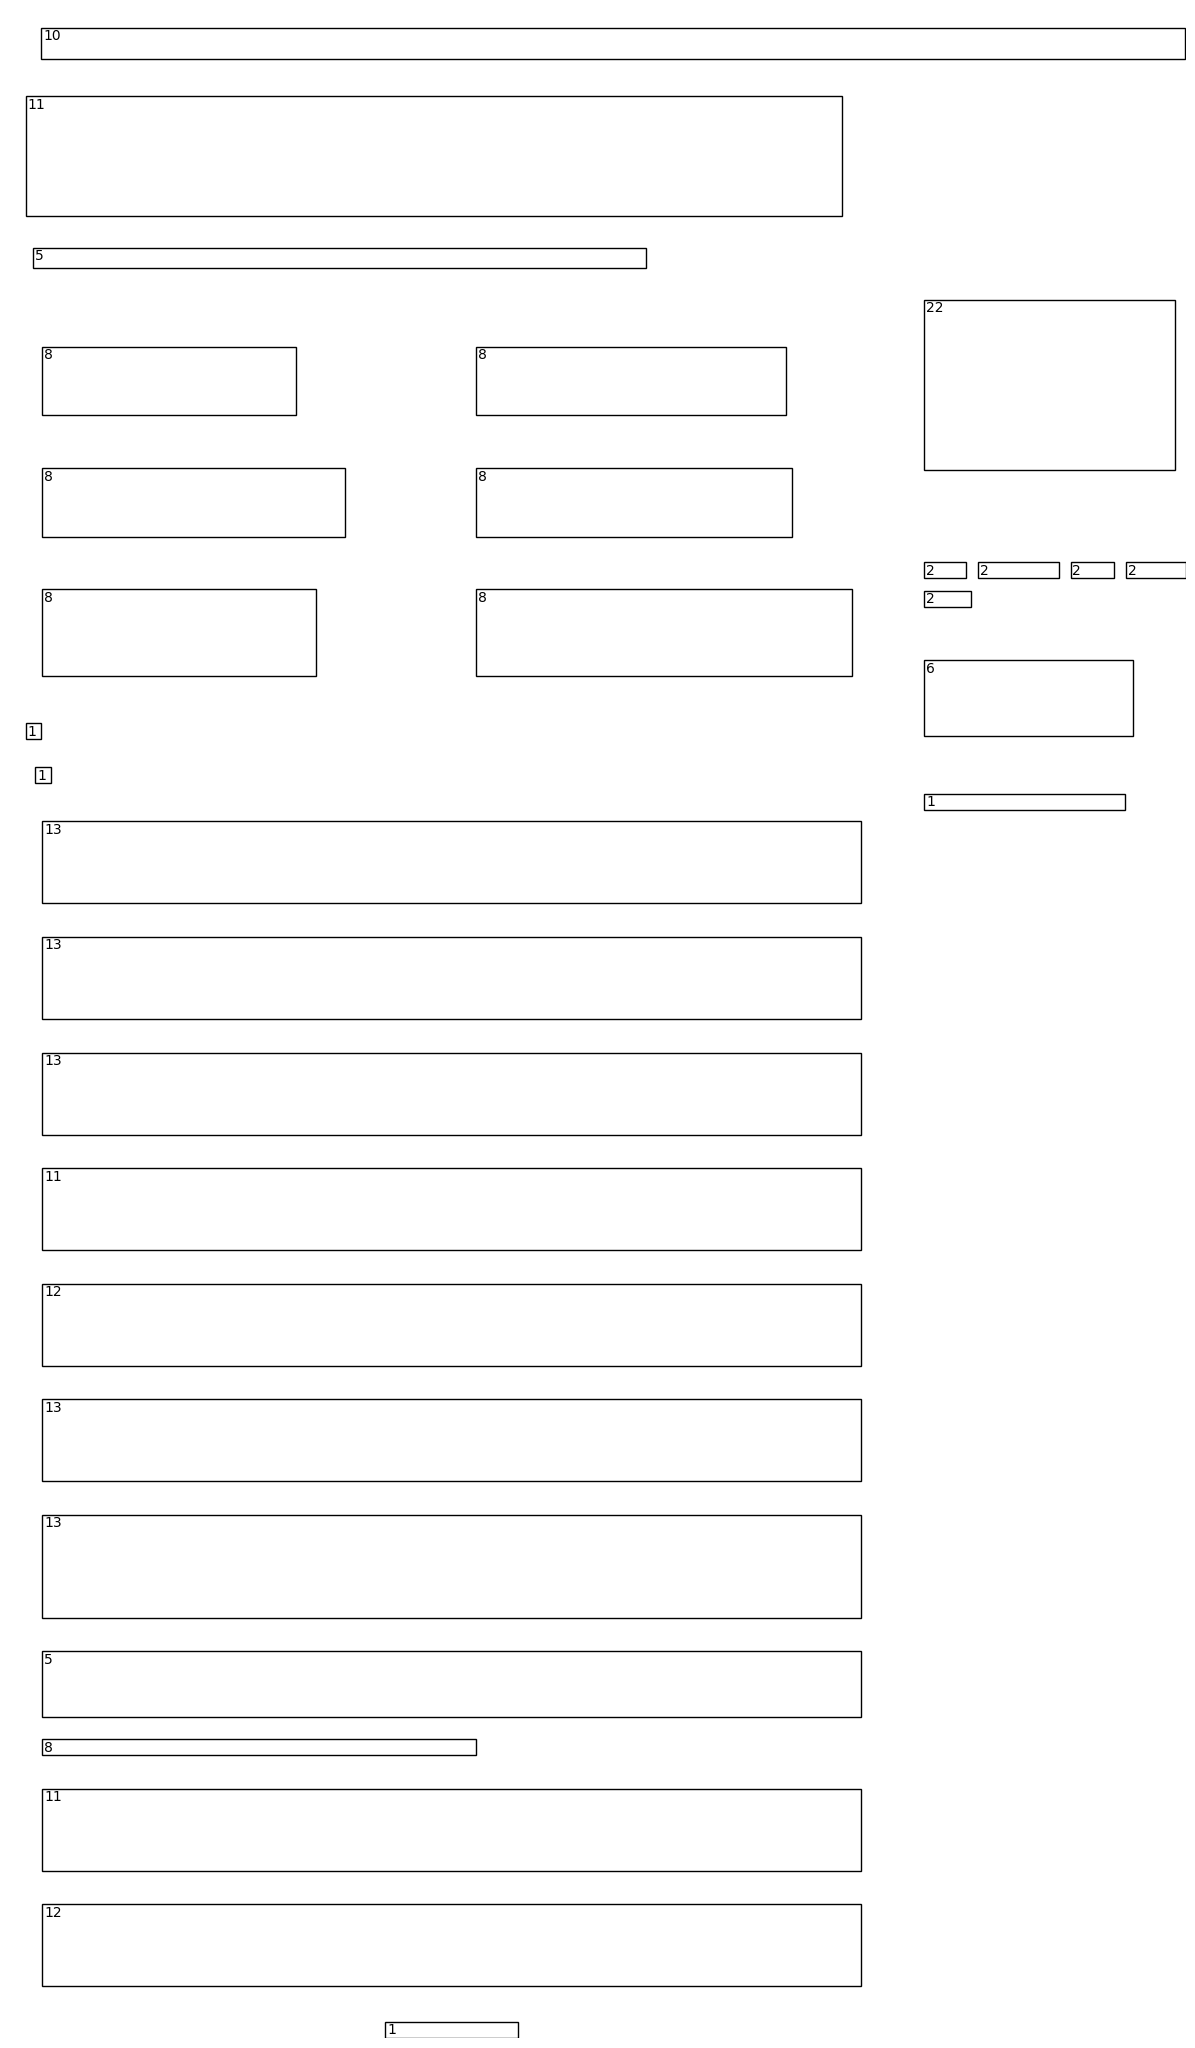

In [10]:
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# --- 1) Load your visual leaves data ---
with open(f'{folder_name}/elements.json', 'r', encoding='utf-8') as f:
    leaves = json.load(f)

# --- 2) Paste in your best‐level mapping here ---
#    (or load from a JSON you dumped in your traversal script)
best_level = instances

# --- 3) For each root, collect all leaves under it and compute its bbox ---
root_boxes = []
for root_xpath, count in best_level.items():
    # find only those leaves whose xpath starts with the root_xpath
    group = [l for l in leaves if l['xpath'].startswith(root_xpath)]
    if not group:
        continue
    min_x = min(l['x'] for l in group)
    min_y = min(l['y'] for l in group)
    max_x = max(l['x'] + l['width'] for l in group)
    max_y = max(l['y'] + l['height'] for l in group)
    root_boxes.append((min_x, min_y, max_x - min_x, max_y - min_y, count))

# --- 4) Determine canvas size from all leaves ---
all_max_x = max(l['x'] + l['width'] for l in leaves)
all_max_y = max(l['y'] + l['height'] for l in leaves)

# --- 5) Draw it!
fig, ax = plt.subplots(figsize=(all_max_x/100, all_max_y/100))
ax.set_xlim(0, all_max_x)
ax.set_ylim(all_max_y, 0)            # flip Y so (0,0) is top‑left
ax.axis('off')

for x, y, w, h, cnt in root_boxes:
    # outline
    rect = Rectangle((x, y), w, h, fill=False)
    ax.add_patch(rect)
    # label the count in top‑left corner
    ax.text(x + 2, y + 12, str(cnt), fontsize=10)

plt.tight_layout()
plt.show()


In [11]:
# 'leaves' is the list you loaded from elements.json
# each item has at least 'xpath', plus its x/y/width/height, etc.
with open(f'{folder_name}/elements.json','r',encoding='utf-8') as f:
    leaves = json.load(f)

# group leaf XPaths under each root‑XPath
instance_details = {}
for root_xpath, count in instances.items():
    grouped = [l for l in leaves if l['xpath'].startswith(root_xpath)]
    instance_details[root_xpath] = {
        'count':  count,
        'leaves': [l['xpath'] for l in grouped]
    }

# pretty‑print
for root, info in instance_details.items():
    print(f"{root} → {info['count']} elements:")
    for leaf_xp in info['leaves']:
        print("    ", leaf_xp)

/html[1]/body[1]/div[1]/div[4]/main[1]/div[1]/div[1]/div[1]/div[2]/div[1]/div[2]/div[1] → 22 elements:
     /html[1]/body[1]/div[1]/div[4]/main[1]/div[1]/div[1]/div[1]/div[2]/div[1]/div[2]/div[1]/div[1]/a[1]/h4[1]
     /html[1]/body[1]/div[1]/div[4]/main[1]/div[1]/div[1]/div[1]/div[2]/div[1]/div[2]/div[1]/div[1]/div[2]/a[1]
     /html[1]/body[1]/div[1]/div[4]/main[1]/div[1]/div[1]/div[1]/div[2]/div[1]/div[2]/div[1]/div[1]/div[1]/a[1]/img[1]
     /html[1]/body[1]/div[1]/div[4]/main[1]/div[1]/div[1]/div[1]/div[2]/div[1]/div[2]/div[1]/div[1]/div[1]/a[2]/img[1]
     /html[1]/body[1]/div[1]/div[4]/main[1]/div[1]/div[1]/div[1]/div[2]/div[1]/div[2]/div[1]/div[1]/div[1]/a[3]/img[1]
     /html[1]/body[1]/div[1]/div[4]/main[1]/div[1]/div[1]/div[1]/div[2]/div[1]/div[2]/div[1]/div[1]/div[1]/a[4]/img[1]
     /html[1]/body[1]/div[1]/div[4]/main[1]/div[1]/div[1]/div[1]/div[2]/div[1]/div[2]/div[1]/div[1]/div[1]/a[5]/img[1]
     /html[1]/body[1]/div[1]/div[4]/main[1]/div[1]/div[1]/div[1]/div[2]/div[1]/

In [12]:
json_path = f"{folder_name}/segmentation.json"
with open(json_path, 'w', encoding='utf-8') as out:
    json.dump(instance_details, out, indent=2, ensure_ascii=False)
print(f"Wrote JSON output to {json_path}")

Wrote JSON output to https_github.com_facebook/segmentation.json
